# 8.2 Training a Bag-of-words Model

## Part 2: Training a Logistic Regression Classifier

# 1 Loading the dataset into DataFrames

In [1]:
# pip install datasets

import os.path as op

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import torch

from sklearn.feature_extraction.text import CountVectorizer

from local_dataset_utilities import download_dataset, load_dataset_into_to_dataframe, partition_dataset
from local_dataset_utilities import IMDBDataset

from local_utilities import LightningModel

In [2]:
download_dataset()

df = load_dataset_into_to_dataframe()
partition_dataset(df)

100%|██████████| 50000/50000 [00:30<00:00, 1654.23it/s]


Class distribution:


In [3]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

## 2) Bag-of-Words Model

In [4]:
cv = CountVectorizer(lowercase=True, max_features=10_000, stop_words="english")

cv.fit(df_train["text"])

X_train = cv.transform(df_train["text"])
X_val = cv.transform(df_val["text"])
X_test = cv.transform(df_test["text"])

## 3) Defining the DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]

In [6]:
train_ds = TextDataset(X_train.todense(), df_train["label"].values)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

In [7]:
val_ds = TextDataset(X_val.todense(), df_val["label"].values)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=True,
)

In [8]:
test_ds = TextDataset(X_test.todense(), df_test["label"].values)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=True,
)

In [9]:
for batch_idx, (features, class_labels) in enumerate(train_loader):
    break

In [10]:
features.shape

torch.Size([32, 10000])

## 4) Implementing the Classifier

In [11]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits
    
    
pytorch_model = LogisticRegression(num_features=10_000, num_classes=2)

In [12]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [13]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=30,
    accelerator="cpu",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/my-model

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | LogisticRegression | 20.0 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


/Users/alimtleuliyev/anaconda3/envs/ds/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/alimtleuliyev/anaconda3/envs/ds/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alimtleuliyev/anaconda3/envs/ds/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Epoch 29: 100%|██████████| 1094/1094 [00:04<00:00, 221.16it/s, v_num=0, val_loss=0.307, val_acc=0.886, train_acc=0.945]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1094/1094 [00:04<00:00, 220.80it/s, v_num=0, val_loss=0.307, val_acc=0.886, train_acc=0.945]


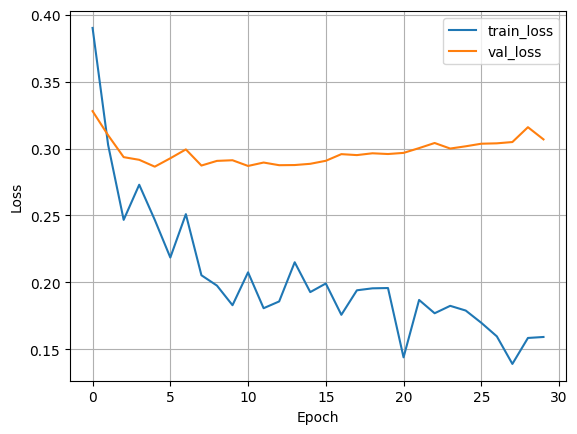

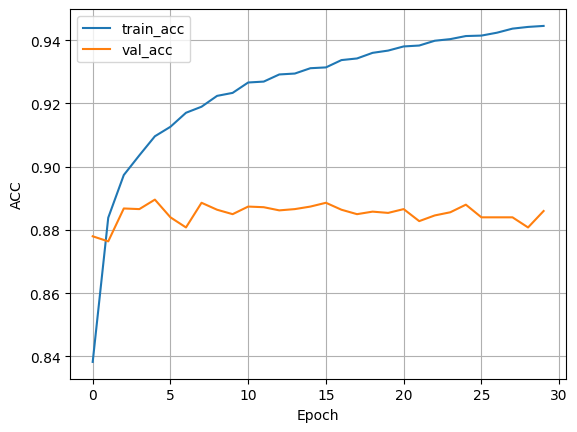

In [14]:
from local_utilities import plot_csv_logger

plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

In [15]:
    §123trainer.test(model=lightning_model, dataloaders=test_loader)

/Users/alimtleuliyev/anaconda3/envs/ds/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/alimtleuliyev/anaconda3/envs/ds/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 313/313 [00:00<00:00, 441.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8847000002861023     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8847000002861023}]

In [16]:
print('Done1')

Done1
